
## Neural Networks for Classification

[ 3  4  5  8 10 11 16 17 18 19 21 22 24 26 28 30 38 42 51 54 58 59 61 65
 66]
--------Epoch1starts--------


E:\ANACON\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test loss：57.988906145095825
Test accuracy：0.2513704001903534
--------Epoch2starts--------
Test loss：50.26116752624512
Test accuracy：0.45184025168418884
--------Epoch3starts--------
Test loss：42.97591197490692
Test accuracy：0.6155050992965698
--------Epoch4starts--------
Test loss：36.60636556148529
Test accuracy：0.7321848273277283
--------Epoch5starts--------
Test loss：30.24352204799652
Test accuracy：0.8065779209136963
--------Epoch6starts--------
Test loss：25.301387667655945
Test accuracy：0.8582615256309509
--------Epoch7starts--------
Test loss：21.835895597934723
Test accuracy：0.887235701084137
--------Epoch8starts--------
Test loss：19.25010234117508
Test accuracy：0.8989819884300232
--------Epoch9starts--------
Test loss：17.28064775466919
Test accuracy：0.9115113615989685
--------Epoch10starts--------
Test loss：15.716998815536499
Test accuracy：0.9169929623603821
--------Epoch11starts--------
Test loss：14.452968418598175
Test accuracy：0.9216914772987366
--------Epoch12starts--------
Te

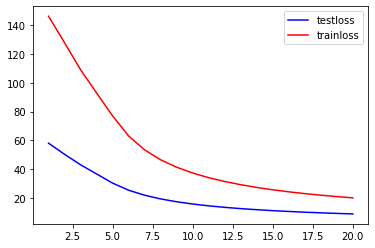

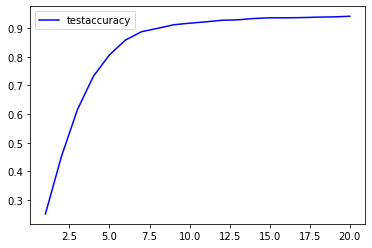

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torch import nn
import os
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import cv2
from CNN_network import CA2Net

indexlist = np.arange(1,69,1)
np.random.shuffle(indexlist)
indexlist = indexlist[0:25]
#indexlist = np.append(indexlist,0)
indexlist.sort()
print(indexlist)
eachclass_num = [len([f for f in os.listdir(os.path.join('PIE', str(s))) if f.endswith('.jpg')]) for s in indexlist]
total_num = sum(eachclass_num)
vector = np.zeros([total_num,32,32])
label = np.zeros([total_num,1])


n=0
for i,cls in enumerate(indexlist):
    for img_path in [f for f in os.listdir(os.path.join('PIE', str(cls))) if f.endswith('.jpg')]:
        img_path = "PIE/"+str(cls)+"/"+img_path
        img_cur = cv2.imread(img_path,0)
        vector[n] = img_cur
        label[n] = i+1
        n += 1

vector = np.reshape(vector,(vector.shape[0],-1))
vector = np.concatenate([vector,label],axis=1)
np.random.shuffle(vector)
label[:,:] = vector[:,1024:1025]
vector = vector[:,0:1024]



self_vector = np.zeros([10,32,32])
self_label = np.zeros([10,1])*26
n=0
for img_path in [f for f in os.listdir(os.path.join('PIE', str(0))) if f.endswith('.jpg')]:
    img_path = "PIE/" + str(0) + "/" + img_path
    img_cur = cv2.imread(img_path, 0)
    self_vector[n] = img_cur
    n += 1
self_vector = np.reshape(self_vector,(self_vector.shape[0],-1))

trainset = vector[0:int(total_num*0.7)]
trainlabel = label[0:int(total_num*0.7)]
testset = vector[int(total_num*0.7):]
testlabel = label[int(total_num*0.7):]

trainset = np.concatenate([trainset,self_vector[0:7]])
trainlabel = np.concatenate([trainlabel,self_label[0:7]])
testset = np.concatenate([testset,self_vector[7:]])
testlabel = np.concatenate([testlabel,self_label[7:]])

trainset = trainset.reshape([trainset.shape[0],1,32,32])
testset = testset.reshape([testset.shape[0],1,32,32])

trainlabel = trainlabel.T[0]
testlabel = testlabel.T[0]

#------------------------------------------------------------------------------------------------------------------------------
class Imagedata(Dataset):
    def __init__(self, imageset, labels):
        self.imageset = imageset
        self.labels = labels

    def __len__(self):
        return self.imageset.shape[0]

    def __getitem__(self, i):
        img = self.imageset[i]
        label = self.labels[i]
        return img, label

trainimg = Imagedata(trainset, trainlabel)
testimg = Imagedata(testset, testlabel)

train_dataloader = DataLoader(dataset=trainimg,batch_size=64)
test_data_loader = DataLoader(dataset=testimg,batch_size=64)


#创建网络模型
NET = CA2Net()
#损失函数
loss_fn = nn.CrossEntropyLoss()
#优化器
learning_rate = 0.005
optimizer = torch.optim.SGD(NET.parameters(),lr = learning_rate)

#记录训练的次数
total_train_step = 0
#记录测试的次数
total_test_step = 0
#训练的轮数
epoch = 20
trainloss = []
testloss = []
testaccuracy = []
for i in range(epoch):
    print("--------Epoch{}starts--------".format(i+1))
    iterloss = 0
    for data in train_dataloader:
        imgs, targets = data
        imgs = imgs.float()
        targets = targets.long()
        outputs = NET(imgs)
        loss = loss_fn(outputs,targets)
        #优化器优化模型
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_step = total_train_step + 1
        iterloss += loss.item()
        #print("num：{} loss：{}".format(total_train_step,loss))
    trainloss.append(iterloss)
    total_test_loss = 0
    total_accuracy = 0
    torch.no_grad()
    for data in test_data_loader:
        imgs, targets = data
        imgs = imgs.float()
        targets = targets.long()
        outputs = NET(imgs)
        loss = loss_fn(outputs,targets)
        total_test_loss = total_test_loss + loss.item()
        accuracy = (outputs.argmax(1) == targets).sum()
        total_accuracy = total_accuracy + accuracy

    print("Test loss：{}".format(total_test_loss))
    print("Test accuracy：{}".format(total_accuracy/len(testset)))
    testloss.append(total_test_loss)
    testaccuracy.append(total_accuracy/len(testset))
    total_test_step = total_test_step + 1
x = np.arange(1,21,1)
plt.figure(1)
plt.plot(x,testloss,'blue',label="testloss")
plt.plot(x,trainloss,"red",label="trainloss")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(x,testaccuracy,'blue',label="testaccuracy")
plt.legend()
plt.show()